In this notebook we have performed below activities to predict Accident level.
1. Preprocessing
2.  Text processing (Tokenize and pad)
2. Imputation
3. Categorical encoder
4. Date transformation
5. pipelines
6. Machine learning model perfomance comparision.
7. Model Tuning
8. Neural Networks

Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tensorflow.keras.models import Model, Sequential
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize,stem,punkt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import lightgbm as lgb
import nltk
from nltk.util import ngrams
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
nltk.download('wordnet')


Output hidden; open in https://colab.research.google.com to view.

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Setting the current working directory

import os; 
os.chdir('/content/drive/MyDrive/Colab Notebooks/Capstone')


In [ ]:
import pandas as pd
#ram 
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description_Dataset_SMOTE.csv")
#satya path /content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv
#data = pd.read_csv("/content/drive/MyDrive/Capstone project/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv")
data.head(3)


,Unnamed: 0,Data,Countries,Local,Industry Sector,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,Accident Level
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,I
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,I
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,I


In [ ]:
data_bkp = data.copy()

In [ ]:
data.rename(columns=
            {'Data':'Date','Genre':'Gender','Industry Sector':'Industry','Accident Level':'Accident','Potential Accident Level':'Potential_Accident','Employee or Third Party':'Emp_Type','Critical Risk':'Critical Risk'},inplace=True)


In [ ]:
data

,Unnamed: 0,Date,Countries,Local,Industry,Potential_Accident,Gender,Emp_Type,Critical Risk,Description,Accident
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,I
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,I
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,I
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,I
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,IV
...,...,...,...,...,...,...,...,...,...,...,...
1575,1575,2016-12-10 00:00:00,Country_01,Local_05,Metals,V,Male,Third Party,Plates,Being 4:15 a.m. on the 179th block of Nv 1880 ...,V
1576,1576,2017-04-13 00:00:00,Country_01,Local_02,Mining,V,Male,Third Party,Others,When positioning the scissor bolter N ° 09 in ...,V
1577,1577,2016-07-10 00:00:00,Country_01,Local_03,Mining,V,Male,Third Party,Poll,Being 5:15 a.m. in the N. in the NV 1710 CX 01...,V
1578,1578,2017-03-18 00:00:00,Country_01,Local_01,Mining,V,Male,Third Party,Projection/Choco,When the mechanical technician proceeded to pe...,V


## Target

In [ ]:
risk_grade = {'I':0,'II':1,'III':2,'IV':3,'V':4,'VI':5}
data['Accident'] = pd.Series([risk_grade[x] for x in data['Accident']], index=data.index)

In [ ]:
y=data['Accident']

In [ ]:
data_x = data.drop(columns ='Accident',axis =1)

## Test train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_x, y, 
    test_size=0.2, random_state=1)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.14, random_state=0)

In [ ]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(1087, 10) (1087,) (177, 10) (177,) (316, 10) (316,)


In [ ]:
X_train.columns

Index(['Unnamed: 0', 'Date', 'Countries', 'Local', 'Industry',
       'Potential_Accident', 'Gender', 'Emp_Type', 'Critical Risk',
       'Description'],
      dtype='object')

# Preprocessing

## Text transformation

In [ ]:
from text_preprocess import * #(custom module)
import re
def clean_text(df, col):
	#print('--'*30); print('Converting headlines to lower case')
	new_col_name = "cleaned_" + str(col)
#	print(new_col_name)
	df.new_col_name = df[col].apply(lambda x : x.lower())
	#print(df.new_col_name[0])

	#print('Replacing apostrophes to the standard lexicons')
	df.new_col_name = df.new_col_name.apply(lambda x : replace_words(x))

	#print('Removing punctuations')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_punctuation(x))

	#print('Removing Numbers')
	df.new_col_name = df.new_col_name.apply(lambda x : ''.join([i for i in x if not i.isdigit()]))

	#print('Applying Lemmatizer')
	df.new_col_name = df.new_col_name.apply(lambda x: lem(x))

	#print('Removing multiple spaces between words')
	df.new_col_name = df.new_col_name.apply(lambda x: re.sub(' +', ' ', x))

	#print('Removing stopwords')
	df.new_col_name = df.new_col_name.apply(lambda x: remove_stopwords(x))

	# remove short words (length < 3)
	#print('Removing short words')
	df.new_col_name = df.new_col_name.apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
	#print('--'*30)
	return(df.new_col_name)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Date Transformation

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin
import pandas as pd
class TemporalVariableEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
       #print("X.shape:",X.shape)
       #print("X.head:",X.head())
       #print("[self.variables :",self.variables)
       #print("X[self.variables]['Date']",X[self.variables]['Date'])
       #print("X['Date']:",X['Date'])
       #print("pd.DatetimeIndex(X):",pd.DatetimeIndex(X[self.variables]['Date']))
        X['month'] = pd.DatetimeIndex(X[self.variables]['Date']).month
        X['year'] = pd.DatetimeIndex(X[self.variables]['Date']).year
        X['day'] = pd.DatetimeIndex(X[self.variables]['Date']).day
#        X['dayname'] = pd.DatetimeIndex(X[self.variables]['Date']).day_name()
        X['weekofyear'] = pd.Int64Index(pd.DatetimeIndex(X[self.variables]['Date']).isocalendar().week)  
       #print("###############################X.shape:",X.shape)
#        enc_attribs=["month", "year", "day","dayname","weekofyear"]
        enc_attribs=["month", "year", "day","weekofyear"]
        X=X.loc[:,enc_attribs]
       #print("enc Dateframe chk",X.head())
        ##X=X.drop('Date',inplace=True)
        #print("df columns",X.columns())
#        one_hot_pipeline= Pipeline([('one_hot_encoder',OneHotEncoder(drop='first'))])
#        X=one_hot_pipeline.fit_transform(X)
       #print("###############################X.shape:",X.shape)
 #      #print("###############################X.head:",X[0,:])
        #print('Date transformed.')
        return X

## Text tokenization and impute

1.   Risk Category
2.   Industry



In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin
import pickle
from sklearn.decomposition import PCA

class ImputeEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        pass
    
    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self
    

    def transform(self, X):
            X = X.copy()
            ##print(X.info())
            ## Lable encoder
            industry = {'Metals':1,'Mining':2,'Others':99}
            X['Industry'] = pd.Series([industry[x] for x in X['Industry']], index=X.index)

            #print('Industry Encoded')
            
            risk_map = {'\nNot applicable': 99,
            'Bees': 1,
            'Venomous Animals': 1,
            'Blocking and isolation of energies': 3,
            'Burn': 3,
            'Confined space': 3,
            'Cut': 3,
            'Machine Protection': 3,
            'Manual Tools': 3,
            'Poll': 3,
            'Projection': 3,
            'Projection of fragments': 3,
            'Projection/Burning': 3,
            'Projection/Choco': 3,
            'Projection/Manual Tools': 3,
            'remains of choco': 3,
            'Suspended Loads': 3,
            'Fall': 4,
            'Fall prevention': 4,
            'Fall prevention (same level)': 4,
            'Electrical installation': 5,
            'Electrical Shock': 5,
            'Plates': 5,
            'Power lock': 5,
            'Chemical substances': 6,
            'Liquid Metal': 7,
            'Pressed': 8,
            'Pressurized Systems': 8,
            'Pressurized Systems / Chemical Substances': 8,
            'Individual protection equipment': 9,
            'Traffic': 10,
            'Vehicles and Mobile Equipment': 11,
            'Others': 99}

            X['Critical Risk'] = pd.Series([risk_map[x] for x in X['Critical Risk']], index=X.index)

            #print('Critical Risk Encoded')

            #Y = X.copy()
           #print("X['Description']:",X['Description'])
            #print("pd.DatetimeIndex(X):",pd.DatetimeIndex(X[self.variables]['Data']))
            X['Cleaned_Description'] = clean_text(X,"Description")
            X_desc=X['Cleaned_Description']
           #print("Cleaned_Description",X_desc.head())
            tokenizer = Tokenizer (num_words = 100)
            tokenizer.fit_on_texts(list(X_desc))
            X_desc = tokenizer.texts_to_sequences(X_desc)
           # print('Cleaned text Tokenized.')

           #print("Tokenized",X_desc)
            #max_len=max( X['cleaned_Description'].apply(lambda x: len(x.split(' '))))
            max_len=100
           #print("max_len",max_len)
            X_pad = pad_sequences(X_desc, maxlen = max_len)
            X_final = pd.DataFrame(X_pad)
  #         #print("padded",X_pad[0,:])
            #print(text_encoded.head())
            #X = X[X['Critical Risk'] == 99]
            #print(X.shape)
            riskpred_model = 'predict_risk.pkl'
            riskpred_model = pickle.load(open(riskpred_model, 'rb'))
            pca=PCA(n_components=45)
            X_processed_pca=pca.fit_transform(X_pad)
            #print("predictions",X[0])
           #print("predictions",X_processed_pca.shape)
            X['predicted_risk'] = riskpred_model.predict(X_processed_pca)
            X['predicted_risk'] = X.apply(lambda x: x['predicted_risk'] if x['Critical Risk']==99 else x['Critical Risk'], axis=1)
            #print("new",Y.info())
           #print(X.head())
          # #print('predicted  risk shape1',X_pred_risk.shape)            
            X_pred_risk = X['predicted_risk'].values
           #print('predicted  risk values shape1',X_pred_risk.shape)             
            X_pred_risk = X_pred_risk.reshape(X_pred_risk.shape[0],1)

           # print('Risk Category imputation complete.')
           #print('predicted  risk shape2',X_pred_risk.shape)
 #           pca=PCA(n_components=50)
            X_processed_pca=pca.fit_transform(X_pad)
##
           
            indpred_model = 'predict_industry.pkl'
            indpred_model = pickle.load(open(indpred_model, 'rb'))
            X['predicted_ind'] = indpred_model.predict(X_processed_pca)
            X['predicted_ind'] = X.apply(lambda x: x['predicted_ind'] if x['Industry']==99 else x['Industry'], axis=1)
           #print('predicted ind',X['predicted_ind'])
            #print("new",Y.info())
           #print(X.tail(20))
            X_pred_ind = X['predicted_ind'].values
            X_pred_ind = X_pred_ind.reshape(X_pred_ind.shape[0],1)

           # print('Industry imputation complete.')

           #print('predicted shape',X_pred_ind.shape)
           ##print('padded X_pad',X_pad.type())
            X_final['pred_risk'] = X_pred_risk
            X_final['pred_ind'] = X_pred_ind
            X = X_final
           #print(X_final.shape)
            return X

## Column Encoder

1. Country
2. Local
3. Emp_Type
4. Potential Accident

In [ ]:
from sklearn.base import BaseEstimator,TransformerMixin
import pandas as pd
class ColumnsLableEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, variables=None):
        
        if not isinstance(variables, list):
            self.variables = [variables]
        else:
            self.variables = variables

    def fit(self, X, y=None):
        # we need this step to fit the sklearn pipeline
        return self

    def transform(self, X):
        X = X.copy()
       
        country = {'Country_01':1,'Country_02':2,'Country_03':3}
      
        local = { 'Local_01': 1,
                  'Local_02': 2,
                  'Local_03': 3,
                  'Local_04': 4,
                  'Local_05': 5,
                  'Local_06': 6,
                  'Local_07': 7,
                  'Local_08': 8,
                  'Local_09': 9,
                  'Local_10': 10,
                  'Local_11': 11,
                  'Local_12': 12 }

        emp = {
                  'Third Party': 1,
                  'Employee': 2,
                  'Third Party (Remote)': 3
        }
        
        risk_grade = {'I':1,'II':2,'III':3,'IV':4,'V':5,'VI':6}        
        

        X['Countries'] = pd.Series([country[x] for x in X['Countries']], index=X.index)
        #print('Countries Encoded')

        X['Local'] = pd.Series([local[x] for x in X['Local']], index=X.index)
        #print('Local Encoded')

        X['Emp_Type'] = pd.Series([emp[x] for x in X['Emp_Type']], index=X.index)
        #print('Emp_type Encoded')

        X['Potential_Accident'] = pd.Series([risk_grade[x] for x in data['Potential_Accident']], index=data.index)
        #print('Potential Accident Encoded')

       # X['Gender'] = pd.Series([country[x] for x in X['Gender']], index=X.index)
      #  X=X.loc[:,enc_attribs]
       #print("enc Dateframe chk",X.head())
       #print("###############################X.shape:",X.shape)
       ##print("###############################X.head:",X[0,:])
        return X

## Pipeline

In [ ]:
#Building the Transformation Pipeline
from sklearn.pipeline import Pipeline
from  sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.decomposition import PCA
import numpy as np
#import skmice
dataframe=data
dataframe_x=dataframe.drop(['Accident'],axis=1)


#date pipeline##################################################
date_attribs=["Date"]
dataframe_date=dataframe.loc[:,date_attribs]
##print("dataframe_date chk" ,dataframe_date.head())
date_pipeline= Pipeline([('date_info_split', TemporalVariableEstimator(date_attribs))])
dataframe_date_tr=date_pipeline.fit_transform(dataframe_date)
#print("Date Pipeline check",dataframe_date_tr)
######################################################################

#OnehotEncoding Pipeline##############################################
#one_hot_attribs=["Local", "Industry", "Emp_Type","Countries","Potential_Accident","Gender"]
one_hot_attribs=["Gender"]
dataframe_onehot=dataframe.loc[:,one_hot_attribs]
#print("Onehot dataframe chk",dataframe_onehot.head())
one_hot_pipeline= Pipeline([('one_hot_encoder',OneHotEncoder(drop='first'))])
#one_hot_pipeline= Pipeline([('one_hot_encoder',LabelEncoder())])
dataframe_oh_tr=one_hot_pipeline.fit_transform(dataframe_onehot)
##print("Onehot Pipeline check",dataframe_oh_tr[0,1])
######################################################################
'''
#Text Pipeline##############################################
text_attribs=['Description']
dataframe_text_enc=dataframe.loc[:,text_attribs]
#print("Text encode  dataframe chk",dataframe_text_enc.head())
text_pipeline= Pipeline([('text_encoder',TextVariableEstimator())])
dataframe_text_enc_tr=text_pipeline.fit_transform(dataframe_text_enc)
#print("Text encoding Pipeline check",dataframe_text_enc_tr[0])
'''
#Risk Pipeline##############################################
risk_attribs=['Critical Risk','Industry','Description']
dataframe_risk_imp=dataframe.loc[:,risk_attribs]
#print("Impute  dataframe chk",dataframe_risk_imp.head())
risk_pipeline= Pipeline([('risk_imputer',ImputeEstimator())])
dataframe_risk_imp_tr=risk_pipeline.fit_transform(dataframe_risk_imp)
#print("Impute Pipeline check",dataframe_risk_imp_tr[0])

'''
#Industry Impute Pipeline###################################
ind_attribs=['Industry','Description']
dataframe_ind_imp=dataframe.loc[:,ind_attribs]
#print("Industry Impute  dataframe chk",dataframe_ind_imp.head())
ind_pipeline= Pipeline([('industry_imputer',IndustryImputeEstimator())])
dataframe_ind_imp_tr=ind_pipeline.fit_transform(dataframe_ind_imp)
#print("Industry Impute Pipeline check",dataframe_ind_imp_tr[0])
'''
#Lable encoder Pipeline##############################################
le_attribs=['Countries','Local','Emp_Type','Potential_Accident']
dataframe_le=dataframe.loc[:,le_attribs]
#print("LE  dataframe chk",dataframe_le.head())
le_pipeline= Pipeline([('risk_imputer',ColumnsLableEncoder())])
dataframe_le_tr=le_pipeline.fit_transform(dataframe_le)
#print("LE Pipeline check",dataframe_le_tr[0:])

In [ ]:
######################################################################
full_pipeline=ColumnTransformer([
                ("datetransform",date_pipeline,date_attribs),
                ("imputer",risk_pipeline, risk_attribs),
            #    ("industryimputer",ind_pipeline, ind_attribs),
            #    ("textencode",text_pipeline,text_attribs)  ,
                ("onehotencode",one_hot_pipeline, one_hot_attribs),
                ("le_encode",le_pipeline, le_attribs)
])
#dataframe_x_tr=full_pipeline.fit_transform(dataframe_x)
#dataframe_x_tr[0,:]


In [ ]:
xtrain_tr=full_pipeline.fit_transform(X_train)
#xval_tr=full_pipeline.fit_transform(X_val)

In [ ]:
xtrain_tr.shape

(1087, 111)

# Machine Learning Models

In [ ]:
pca = PCA(n_components=.9999999999)

In [ ]:
pca_test= pca.fit_transform(xtrain_tr)
pca_test.shape

(1087, 45)

In [ ]:
# Hyper Parameter Tuning for full data
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from sklearn.model_selection import SVC

seed=42
pipe_steps = [('data_transaform',full_pipeline), 
               ('scalar',StandardScaler()),
              ('pca', PCA())
          #  , ('RF', RandomForestClassifier(random_state=seed, min_samples_leaf=2))
            #, ('svc',SVC())
            ]

check_params= {
    'pca__n_components': [45], 
    'RF__max_depth': [18,20,22]
    #'RF__n_estimators' :[300,500,900],
    #'RF__max_features' : [5,6],
    #'RF__ccp_alpha' : [0.05,0.1]
}
pca_pipeline = Pipeline(pipe_steps)

In [ ]:
# Compare Algorithms for full data
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb


x_train_tr=pca_pipeline.fit_transform(X_train)
# prepare configuration for cross validation test harness
seed = 42
# prepare models
models = []
models.append(('BR', BaggingClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('SVM', SVC(kernel='linear')))
models.append(('NB',GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5, random_state=seed)
	cv_results = model_selection.cross_val_score(model, x_train_tr, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

BR: 0.482074 (0.027146)
XGB: 0.541914 (0.033724)
RF: 0.540942 (0.011935)
CART: 0.423122 (0.030868)
GB: 0.551051 (0.029315)
SVM: 0.596208 (0.037043)
NB: 0.381711 (0.060217)


## Compare machine learning model performances

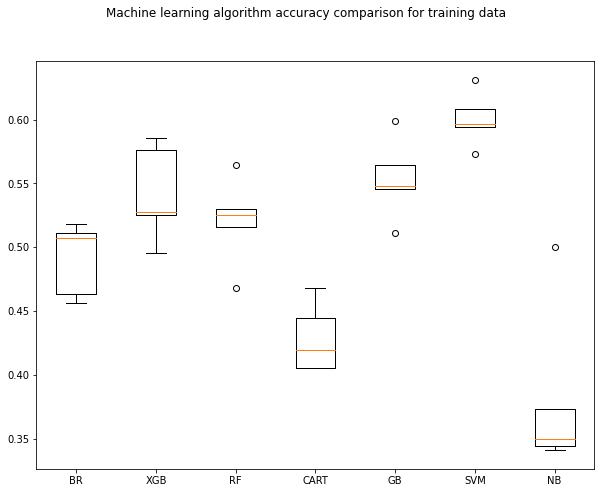

In [ ]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(10,7.5))
fig.suptitle('Machine learning algorithm accuracy comparison for training data')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## SVC Hyper Tuning

### Random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from scipy import stats

svc_pipe_steps = [('data_transaform',full_pipeline), 
               ('scalar',StandardScaler()),
              ('pca', PCA())
            , ('SVC', SVC(random_state=seed))]


#{'SVC__C': 0.1, 'SVC__gamma': 1, 'SVC__kernel': 'linear', 'pca__n_components': 45

svc_rs_check_params= {
    'pca__n_components': [45], 
    'SVC__C':stats.uniform(0.01, 2),
    'SVC__gamma':stats.uniform(1, 5), 
    'SVC__kernel':['linear','rbf']
}

svc_rs_hptuning_pipe = Pipeline(svc_pipe_steps)

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
   # create_grid = GridSearchCV(svc_hptuning_pipe, param_grid=svc_check_params, cv=cv,verbose = 2,scoring=)
    rand_search = RandomizedSearchCV(svc_rs_hptuning_pipe, param_distributions = svc_rs_check_params, n_iter = 30, cv = cv) 
    rand_search.fit(X_train, y_train)
    print ("score for %d fold CV := %3.2f" %(cv, rand_search.score(X_val, y_val)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (rand_search.best_params_)
    best_model=rand_search.best_estimator_
    print("Best Model :",best_model)
  

print ("out of the loop")

Start Fitting Training Data


score for 4 fold CV := 0.59
!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'SVC__C': 0.05770301272014699, 'SVC__gamma': 3.2346364044821243, 'SVC__kernel': 'linear', 'pca__n_components': 45}
Best Model : Pipeline(memory=None,
         steps=[('data_transaform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('datetransform',
                                                  Pipeline(memory=None,
                                                           steps=[('date_info_split',
                                                                   TemporalVariableEstimator(variables=['Date']))],
                                                           verbose=False),
                                                  ['Date']),
                                                 ('imputer',


### Grid searh

In [ ]:

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

svc_pipe_steps = [('data_transaform',full_pipeline), 
               ('scalar',StandardScaler()),
              ('pca', PCA())
            , ('SVC', SVC(random_state=seed))]


#{'SVC__C': 0.1, 'SVC__gamma': 1, 'SVC__kernel': 'linear', 'pca__n_components': 45

svc_check_params= {
    'pca__n_components': [45], 
    'SVC__C':[0.035,0.037],
    'SVC__gamma':[.5,1,2], 
    'SVC__kernel':['linear']
}

svc_hptuning_pipe = Pipeline(svc_pipe_steps)

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
    create_grid = GridSearchCV(svc_hptuning_pipe, param_grid=svc_check_params, cv=cv,verbose = 2)
    create_grid.fit(X_train, y_train)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_val, y_val)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)
    best_model=create_grid.best_estimator_
    print("Best Model :",best_model)
  

print ("out of the loop")

Start Fitting Training Data


Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] SVC__C=0.035, SVC__gamma=0.5, SVC__kernel=linear, pca__n_components=45 
Date transformed.
Industry Encoded
Critical Risk Encoded
------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned text Tokenized.
Risk Category imputation complete.
Industry imputation complete.
Countries Encoded
Local Encoded
Emp_type Encoded
Potential Accident Encoded
Date transformed.
Industry Encoded
Critical Risk Encoded
------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned text Tokenized.
Risk Category imputation complete.
Industry imputation complete.
Countries Encoded
Local Encoded
Emp_type Encoded
Potential Accident Encoded
[CV]  SVC__C=0.035, SVC__gamma=0.5, SVC__kernel=linear, pca__n_components=45, total=   5.2s
[CV] SVC__C=0.035, 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned text Tokenized.
Risk Category imputation complete.
Industry imputation complete.
Countries Encoded
Local Encoded
Emp_type Encoded
Potential Accident Encoded
Date transformed.
Industry Encoded
Critical Risk Encoded
------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned text Tokenized.
Risk Category imputation complete.
Industry imputation complete.
Countries Encoded
Local Encoded
Emp_type Encoded
Potential Accident Encoded
[CV]  SVC__C=0.035, SVC__gamma=0.5, SVC__kernel=linear, pca__n_components=45, total=   5.0s
[CV] SVC__C=0.035, 

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.0min finished


Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned text Tokenized.
Risk Category imputation complete.
Industry imputation complete.
Countries Encoded
Local Encoded
Emp_type Encoded
Potential Accident Encoded
Date transformed.
Industry Encoded
Critical Risk Encoded
------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned text Tokenized.
Risk Category imputation complete.
Industry imputation complete.
Countries Encoded
Local Encoded
Emp_type Encoded
Potential Accident Encoded
score for 4 fold CV := 0.59
!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'SVC__C': 0.037, 'S

In [ ]:
print('TRAIN:',best_model.score(X_train,y_train))
print ('\n')
print('VALIDATION:',best_model.score(X_val,y_val))
print ('\n')
print('TEST:',best_model.score(X_test,y_test))

TRAIN: 0.6678932842686293


VALIDATION: 0.5875706214689266


TEST: 0.569620253164557


In [ ]:
pd.DataFrame(best_model.predict(X_test)).value_counts()

4    80
2    67
3    65
1    53
0    51
dtype: int64

In [ ]:
from sklearn.metrics import classification_report
print (classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.55      0.40      0.46        70
           1       0.51      0.40      0.45        68
           2       0.33      0.49      0.39        45
           3       0.52      0.53      0.53        64
           4       0.86      1.00      0.93        69

    accuracy                           0.57       316
   macro avg       0.55      0.56      0.55       316
weighted avg       0.57      0.57      0.56       316



In [ ]:
y.value_counts()

5    316
4    316
3    316
2    316
1    316
Name: Accident, dtype: int64

In [ ]:
print (classification_report(y_train, best_model.predict(X_train)))


Date transformed.
Industry Encoded
Critical Risk Encoded
------------------------------------------------------------
Converting headlines to lower case
cleaned_Description
Replacing apostrophes to the standard lexicons
Removing punctuations
Removing Numbers
Applying Lemmatizer
Removing multiple spaces between words
Removing stopwords
Removing short words
------------------------------------------------------------
Cleaned text Tokenized.
Risk Category imputation complete.
Industry imputation complete.
Countries Encoded
Local Encoded
Emp_type Encoded
Potential Accident Encoded
              precision    recall  f1-score   support

           1       0.61      0.52      0.56       214
           2       0.66      0.53      0.59       212
           3       0.54      0.68      0.60       231
           4       0.59      0.57      0.58       214
           5       0.92      1.00      0.96       216

    accuracy                           0.66      1087
   macro avg       0.66      0.66   

In [ ]:
import pickle
filename = 'capstone_NLP_ML_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

In [ ]:
'''# get prediction  column cleaned data
X_Test =data_val['cleaned_Description'].values
y_Test =data_val['Critical Risk'].values
#tokenize
tokenizer.fit_on_texts(list(X_Test))
# to sequences
X_Test = tokenizer.texts_to_sequences(X_Test)
X_Test = pad_sequences(X_Test, maxlen = maxlen)


# scalar
X_Test_sc = sc.transform(X_Test)
# pca
X_Test_pca = pca.transform(X_Test_sc)
'''

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
print(loaded_model)
result = loaded_model.predict(X_test)
print(result) 

Pipeline(memory=None,
         steps=[('data_transaform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('datetransform',
                                                  Pipeline(memory=None,
                                                           steps=[('date_info_split',
                                                                   TemporalVariableEstimator(variables=['Date']))],
                                                           verbose=False),
                                                  ['Date']),
                                                 ('imputer',
                                                  Pipeline(memory=None,
                                                           steps=[('risk_imputer',
                                                                 

### Additional models for reference

## XGBoost Hyper Tuning

In [ ]:
# Hyper Parameter Tuning for Cluster 0

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer

xgb_pipe_steps = [('data_transaform',full_pipeline), 
               ('scalar',StandardScaler()),
              ('pca', PCA())
            , ('XGB', xgb.XGBClassifier(random_state=seed))]

xgb_check_params= {
    'pca__n_components': [45], 
    'XGB__max_depth': [17,20,25,30], 
    'XGB__min_child_weight' : [5,10],
    'XGB__n_estimators' : [500,900],
    'XGB__eta' : [0.0005,0.001,0.005],
    'XGB__learning_rate' : [0.1,0.5,1],
}

xgb_hptuning_pipe = Pipeline(xgb_pipe_steps)

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
    create_grid = GridSearchCV(xgb_hptuning_pipe, param_grid=xgb_check_params, cv=cv)
    create_grid.fit(X_train, y_train)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_val, y_val)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)
    best_model=create_grid.best_estimator_
    print("Best Model :",best_model)
  

print ("out of the loop")

Start Fitting Training Data


score for 4 fold CV := 0.61
!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'XGB__eta': 0.0005, 'XGB__learning_rate': 0.1, 'XGB__max_depth': 25, 'XGB__min_child_weight': 5, 'XGB__n_estimators': 500, 'pca__n_components': 45}
Best Model : Pipeline(memory=None,
         steps=[('data_transaform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('datetransform',
                                                  Pipeline(memory=None,
                                                           steps=[('date_info_split',
                                                                   TemporalVariableEstimator(variables=['Date']))],
                                                           verbose=False),
                                                  ['Date']),
                            

In [ ]:
print('TRAIN:',best_model.score(X_train,y_train))
print ('\n')
print('VALIDATION:',best_model.score(X_val,y_val))
print ('\n')
print('TEST:',best_model.score(X_test,y_test))

TRAIN: 0.9972401103955841


VALIDATION: 0.6101694915254238


TEST: 0.5379746835443038


## Randomforest Hypertuning

In [ ]:
# Hyper Parameter Tuning for full data
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
seed=42
rf_pipe_steps = [('data_transaform',full_pipeline), 
              ('scalar',StandardScaler()),
              ('pca', PCA(45))
            , ('RF', RandomForestClassifier(random_state=seed, min_samples_leaf=2))
           # , ('svc',SVC())
            ]

check_params= {
    #'pca__n_components': [45], 
    'RF__max_depth': [18,20,22]
   # 'RF__n_estimators' :[300,500,900]
   # 'RF__max_features' : [5,6],
   # 'RF__ccp_alpha' : [0.05,0.1]
}
pca_rf_pipeline = Pipeline(rf_pipe_steps)

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")


print ("Start Fitting Training Data")
for cv in tqdm(range(4,5)):
  #  create_grid = GridSearchCV(pca_clf_pipeline, param_grid=check_params, cv=cv)
    create_grid = GridSearchCV(pca_rf_pipeline, param_grid=check_params, cv=cv)
    create_grid.fit(X_train, y_train)
  #  print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_val, y_val)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)
    best_model=create_grid.best_estimator_
    print("Best Model :",best_model)
  

print ("out of the loop")

Start Fitting Training Data


!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'RF__max_depth': 18}
Best Model : Pipeline(memory=None,
         steps=[('data_transaform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('datetransform',
                                                  Pipeline(memory=None,
                                                           steps=[('date_info_split',
                                                                   TemporalVariableEstimator(variables=['Date']))],
                                                           verbose=False),
                                                  ['Date']),
                                                 ('imputer',
                                                  Pipeline(memory=None,
                                                  

In [ ]:
best_model

Pipeline(memory=None,
         steps=[('data_transaform',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('datetransform',
                                                  Pipeline(memory=None,
                                                           steps=[('date_info_split',
                                                                   TemporalVariableEstimator(variables=['Date']))],
                                                           verbose=False),
                                                  ['Date']),
                                                 ('imputer',
                                                  Pipeline(memory=None,
                                                           steps=[('risk_imputer',
                                                                 

In [ ]:
print('TRAIN:',best_model.score(X_train,y_train))
print ('\n')
print('VALIDATION:',best_model.score(X_val,y_val))
print ('\n')
print('TEST:',best_model.score(X_test,y_test))

TRAIN: 0.9972401103955841


VALIDATION: 0.5706214689265536


TEST: 0.5158227848101266


# Neural Nets

In [ ]:
import tensorflow as tf
import keras
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import BatchNormalization,Dropout
from keras.layers import Activation

In [ ]:
# Hyper Parameter Tuning for full data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

seed=42
nn_pipe_steps = [('data_transaform',full_pipeline), 
               ('scalar',StandardScaler())
            ]
nn_pipeline = Pipeline(nn_pipe_steps)

In [ ]:
X_train_nn = nn_pipeline.fit_transform(X_train)
X_val_nn = nn_pipeline.fit_transform(X_val)
X_test_nn = nn_pipeline.fit_transform(X_test)

In [ ]:
epochs=70 # 60
sgd = SGD()
input_dim = X_train_nn.shape[1]
batch_size = int(input_dim/10)
num_classes = 5

In [ ]:
y_train.value_counts()

2    231
4    216
3    214
0    214
1    212
Name: Accident, dtype: int64

In [ ]:
y_train_nn = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_nn = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_nn = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
print('Final Tensors shape before training')
print('Training set', X_train_nn.shape, y_train_nn.shape)
print('Validation set', X_val_nn.shape, y_val_nn.shape)
print('Test set', X_test_nn.shape, y_test_nn.shape)

Final Tensors shape before training
Training set (1087, 111) (1087, 5)
Validation set (177, 111) (177, 5)
Test set (316, 111) (316, 5)


In [ ]:
# build the model

seq = Sequential()
seq.add(Dense(512, input_dim = input_dim))
seq.add(Activation('relu'))    
seq.add(Dense(256))                 
seq.add(Activation('relu'))
seq.add(Dense(126))                   
seq.add(Activation('relu'))  
seq.add(Dense(64))                   
seq.add(Activation('relu'))   
seq.add(Dense(5, activation=tf.nn.softmax))

# compile the model
seq.compile(loss='categorical_crossentropy',
              optimizer= 'Adam',
              metrics=['acc'])

In [ ]:
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               57344     
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 126)               32382     
_________________________________________________________________
activation_2 (Activation)    (None, 126)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [ ]:
%%time

simple_model_history = seq.fit(X_train_nn, y_train_nn,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val_nn, y_val_nn)
                    )

Epoch 1/70
99/99 [==============================] - 1s 5ms/step - loss: 1.4330 - acc: 0.3684 - val_loss: 1.0563 - val_acc: 0.5198
Epoch 2/70
99/99 [==============================] - 0s 3ms/step - loss: 0.8485 - acc: 0.6205 - val_loss: 0.8984 - val_acc: 0.5989
Epoch 3/70
99/99 [==============================] - 0s 3ms/step - loss: 0.7484 - acc: 0.6747 - val_loss: 1.0039 - val_acc: 0.5989
Epoch 4/70
99/99 [==============================] - 0s 3ms/step - loss: 0.7064 - acc: 0.6948 - val_loss: 0.9235 - val_acc: 0.6045
Epoch 5/70
99/99 [==============================] - 0s 3ms/step - loss: 0.5941 - acc: 0.7488 - val_loss: 1.0220 - val_acc: 0.6215
Epoch 6/70
99/99 [==============================] - 0s 3ms/step - loss: 0.4630 - acc: 0.8065 - val_loss: 1.0075 - val_acc: 0.6441
Epoch 7/70
99/99 [==============================] - 0s 3ms/step - loss: 0.4126 - acc: 0.8516 - val_loss: 1.1261 - val_acc: 0.6441
Epoch 8/70
99/99 [==============================] - 0s 3ms/step - loss: 0.3479 - acc: 0.87

<Figure size 720x540 with 0 Axes>

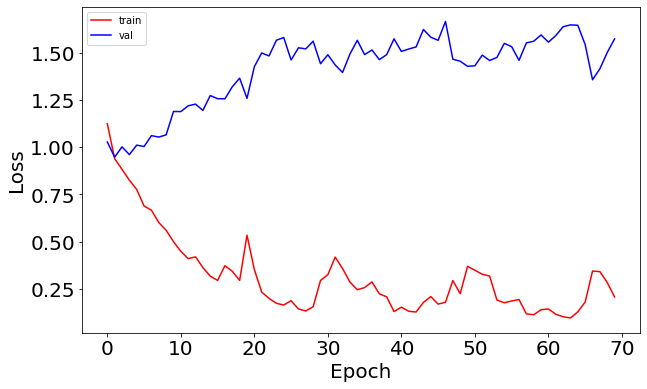

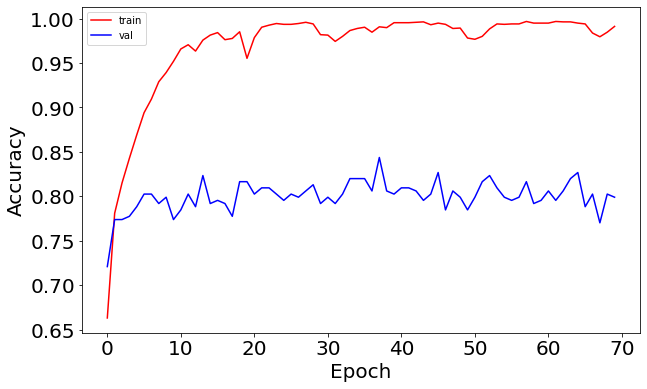

In [ ]:
fig = plt.figure(figsize=(10,7.5))
fig.suptitle('Machine learning algorithm accuracy comparison for training data')

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(simple_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(simple_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)
print('\n')
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(simple_model_history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(simple_model_history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
Simple_results = seq.evaluate(X_test_nn, y_test_nn)

10/10 [==============================] - 0s 2ms/step - loss: 2.6366 - acc: 0.6297


In [ ]:
print('Test accuracy: ', Simple_results)

Test accuracy:  [2.6366324424743652, 0.6297468543052673]


In [ ]:
from sklearn.metrics import classification_report
print (classification_report(y_test, np.argmax(seq.predict(X_test_nn),axis =1)))

              precision    recall  f1-score   support

           0       0.60      0.44      0.51        70
           1       0.53      0.51      0.52        68
           2       0.41      0.62      0.50        45
           3       0.62      0.59      0.61        64
           4       0.94      0.94      0.94        69

    accuracy                           0.62       316
   macro avg       0.62      0.62      0.62       316
weighted avg       0.64      0.62      0.62       316



In [ ]:
np.argmax(seq.predict(X_test_nn),axis =1)

array([1, 3, 4, 1, 1, 4, 0, 2, 1, 1, 1, 0, 4, 4, 2, 2, 0, 1, 2, 0, 4, 0,
       3, 3, 0, 1, 4, 4, 1, 3, 1, 0, 2, 3, 0, 2, 1, 0, 2, 3, 2, 1, 1, 0,
       3, 3, 4, 4, 4, 0, 0, 2, 2, 4, 0, 4, 1, 4, 1, 3, 3, 4, 2, 4, 4, 4,
       4, 4, 0, 2, 1, 3, 3, 2, 3, 1, 4, 4, 2, 4, 4, 0, 3, 3, 2, 0, 2, 1,
       3, 3, 0, 1, 2, 2, 4, 0, 3, 0, 1, 1, 0, 2, 1, 1, 2, 4, 1, 3, 2, 2,
       3, 2, 3, 1, 4, 4, 2, 2, 2, 4, 3, 3, 0, 2, 0, 1, 3, 3, 0, 1, 2, 1,
       0, 0, 1, 4, 0, 4, 2, 1, 2, 3, 4, 3, 0, 4, 1, 0, 3, 1, 4, 3, 3, 3,
       2, 2, 3, 0, 0, 2, 2, 0, 2, 3, 0, 4, 2, 2, 3, 1, 2, 1, 3, 1, 2, 1,
       1, 4, 3, 3, 4, 4, 2, 2, 4, 4, 1, 4, 4, 4, 3, 0, 2, 1, 3, 1, 0, 3,
       0, 0, 2, 1, 2, 2, 2, 1, 0, 1, 4, 2, 4, 1, 0, 1, 1, 2, 4, 1, 1, 3,
       4, 3, 2, 2, 0, 1, 2, 0, 1, 1, 0, 0, 2, 3, 3, 4, 4, 2, 4, 2, 2, 1,
       0, 1, 3, 0, 0, 3, 4, 3, 4, 2, 3, 3, 4, 4, 2, 4, 3, 4, 3, 0, 1, 2,
       1, 2, 1, 0, 2, 4, 4, 0, 2, 2, 4, 3, 3, 4, 3, 1, 1, 4, 1, 2, 4, 3,
       4, 1, 4, 0, 3, 2, 4, 0, 2, 4, 1, 2, 2, 3, 1,